In [14]:
# Import required packages
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
import os
import warnings
import matplotlib.pyplot as plt 
import seaborn as sns
warnings.filterwarnings("ignore")

In [15]:
# split a univariate time series into patterns
def get_Patterns(TSeries, n_inputs,h):
    X,y,z = pd.DataFrame(np.zeros((len(TSeries)-n_inputs-h+1,n_inputs))), pd.DataFrame(), pd.DataFrame()
    for i in range(len(TSeries)):
        # find the end of this pattern
        end_ix = i + n_inputs + h - 1
        # check if we are beyond the time series
        if end_ix > len(TSeries)-1:
            break
        # gather input and output parts of the pattern
        for j in range(n_inputs):
            X.loc[i,j]=TSeries.iloc[i+j,0]
        i=i+n_inputs
        y=y.append(TSeries.iloc[end_ix], ignore_index = True)
    return X,y

In [16]:
# originalData should be a Column Vectored DataFrame
def minmaxNorm(originalData, lenTrainValidation):
    # Maximum Value
    max2norm=max(originalData.iloc[0:lenTrainValidation,0])
    # Minimum Value
    min2norm=min(originalData.iloc[0:lenTrainValidation,0])
    lenOriginal=len(originalData)
    normalizedData=np.zeros(lenOriginal)   
    normalizedData = []
    #Normalize using Min-Max Normalization
    for i in range (lenOriginal):
        normalizedData.append((originalData.iloc[i]-min2norm)/(max2norm-min2norm))    
    return pd.DataFrame(normalizedData)

In [17]:
# originalData and forecastedData should be Column Vectored DataFrames
def minmaxDeNorm( originalData, forecastedData, lenTrainValidation):
    # Maximum Value
    max2norm=max(originalData.iloc[0:lenTrainValidation,0])
    # Minimum Value
    min2norm=min(originalData.iloc[0:lenTrainValidation,0])
    lenOriginal=len(originalData)
    denormalizedData=[]   
    #De-Normalize using Min-Max Normalization
    for i in range (lenOriginal):
        denormalizedData.append((forecastedData.iloc[i]*(max2norm-min2norm))+min2norm)  
    return pd.DataFrame(denormalizedData)

In [18]:
# Timeseries_Data and forecasted_value should be Column Vectored DataFrames
def findRMSE( Timeseries_Data, forecasted_value,lenTrainValidation):
    l=Timeseries_Data.shape[0]
    lenTest=l-lenTrainValidation
    # RMSE on Train & Validation Set
    trainRMSE=0;
    for i in range (lenTrainValidation):
        trainRMSE=trainRMSE+np.power((forecasted_value.iloc[i,0]-Timeseries_Data.iloc[i,0]),2) 
    trainRMSE=np.sqrt(trainRMSE/lenTrainValidation)
    # RMSE on Test Set
    testRMSE=0;
    for i in range (lenTrainValidation,l,1):
        testRMSE=testRMSE+np.power((forecasted_value.iloc[i,0]-Timeseries_Data.iloc[i,0]),2)
    testRMSE=np.sqrt(testRMSE/lenTest)
    return trainRMSE, testRMSE 

In [19]:
# Timeseries_Data and forecasted_value should be Column Vectored DataFrames
def findMAE(Timeseries_Data, forecasted_value,lenTrainValidation):
    l=Timeseries_Data.shape[0]
    lenTest=l-lenTrainValidation
    # MAE on Train & Validation Set
    trainMAE=0;
    for i in range (lenTrainValidation):
        trainMAE=trainMAE+np.abs(forecasted_value.iloc[i,0]-Timeseries_Data.iloc[i,0]) 
    trainMAE=(trainMAE/(lenTrainValidation));
    # MAE on Test Set
    testMAE=0;
    for i in range (lenTrainValidation,l,1):
        testMAE=testMAE+np.abs(forecasted_value.iloc[i,0]-Timeseries_Data.iloc[i,0])
    testMAE=(testMAE/lenTest);
    return trainMAE, testMAE

In [20]:
def Find_Fitness(x,y,lenValid,lenTest,model):
    NOP=y.shape[0]
    lenTrain=NOP-lenValid-lenTest
    xTrain=x.iloc[0:lenTrain,:]
    xValid=x.iloc[lenTrain:(lenTrain+lenValid),:]
    xTest=x.iloc[(lenTrain+lenValid):NOP,:]
    yTrain=y.iloc[0:lenTrain,0]
    yValid=y.iloc[lenTrain:(lenTrain+lenValid),0]
    yTest=y.iloc[(lenTrain+lenValid):NOP,0]
    model.fit(xTrain, yTrain)
    yhatNorm=model.predict(x).flatten().reshape(x.shape[0],1)
    return pd.DataFrame(yhatNorm)

In [21]:
#Read the Time Series Dataset
Timeseries_Data=pd.read_csv('Lynx.csv',header=None)
Timeseries_Data.describe()

,0
count,114.000000
mean,1538.017544
std,1585.843914
min,39.000000
25%,348.250000
50%,771.000000
75%,2566.750000
max,6991.000000


The Autocorrelation plot for the data is:


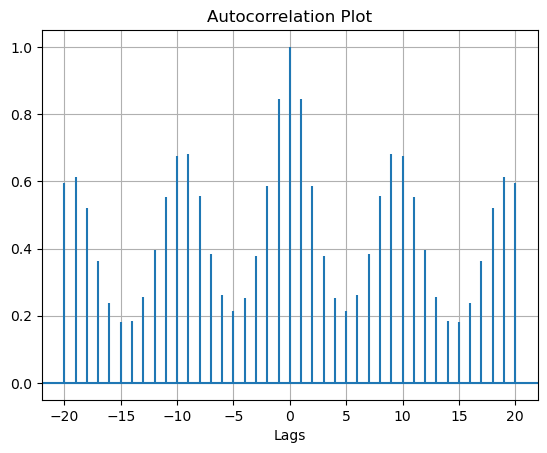

In [22]:
plt.title("Autocorrelation Plot") 
# Providing x-axis name.
plt.xlabel("Lags") 
# Plotting the Autocorrelation plot.
plt.acorr(np.array(Timeseries_Data.iloc[:,0], dtype=float), maxlags = 20) 
# Displaying the plot.
print("The Autocorrelation plot for the data is:")
plt.grid(True)
plt.show() 

<Axes: ylabel='Count'>

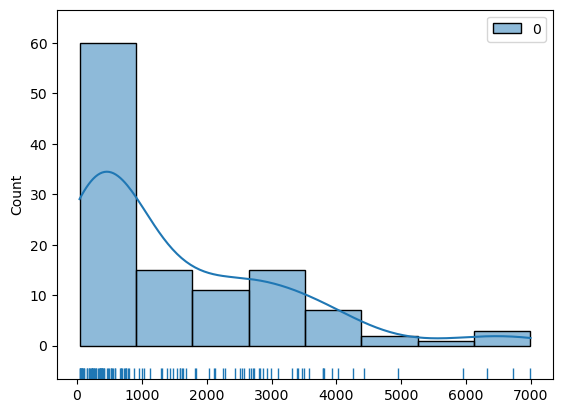

In [23]:
#4. Rug plot — sns.rugplot()
sns.rugplot(data=Timeseries_Data, height=.03, color='darkblue')
sns.histplot(data=Timeseries_Data, kde=True)

In [26]:
LagLength=10
h=1
lt=Timeseries_Data.shape[0]
lenTrain=int(round(lt*0.7))
lenValidation=int(round(lt*0.15))
lenTest=int(lt-lenTrain-lenValidation)
# NORMALIZE THE DATA
normalizedData=minmaxNorm(Timeseries_Data,lenTrain+lenValidation);
# Transform the Time Series into Patterns Using Sliding Window
X, y = get_Patterns(normalizedData, LagLength, h)
model=LinearRegression()
name='LinearRegression'
file1='./'+str(name)+"_Accuracy.xlsx"
file2='./'+str(name)+"_Forecasts.xlsx"
Forecasts=pd.DataFrame()
Accuracy=pd.DataFrame()
ynorm1=Find_Fitness(X,y,lenValidation,lenTest,model)
ynorm=pd.DataFrame(normalizedData.iloc[0:(LagLength+h-1),0])
ynorm=ynorm.append(ynorm1,ignore_index = True)
yhat=minmaxDeNorm(Timeseries_Data, ynorm, lenTrain+lenValidation)
Accuracy.loc[1,0],Accuracy.loc[i,1]=findRMSE( Timeseries_Data,yhat,lenTrain+lenValidation)
Accuracy.loc[1,2],Accuracy.loc[i,3]=findMAE( Timeseries_Data,yhat,lenTrain+lenValidation)
Forecasts=Forecasts.append(yhat.T,ignore_index = True)
Accuracy.to_excel(file1,sheet_name='Accuracy',index=False)
Forecasts.to_excel(file2,sheet_name='Forecasts',index=False)
print(Accuracy)

AttributeError: 'DataFrame' object has no attribute 'append'